# 02 - Entropy Rate Plots

## Imports

In [1]:
import avn.syntax as syntax
import avn.plotting as plotting
import avn.dataloading as dataloading

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

c:\Users\tkoch\anaconda3\envs\fresh_avn_dev\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Compile List of Birds

In [2]:
All_Birds = ["B145", "B236", "B258", "B385", "B402", "B447", 
             "B507", "G255", "G397", "G402", "G413", "G437", 
             "G439", "G524", "G528", "O144", "O254", "O421", 
             "O440", "O512", "R402", "R425", "R469", "S132", 
             "S421", "S525", "S528", "Y389", "Y397", "Y425", 
             "Y440", "B524", "O434", "Y433", "Y453"] 

#All_Birds should contain 35 bird IDs. Check: 
len(All_Birds)

35

## Calculate Entropy Rates with UMAP + WSEG Labels

In [3]:
bird_level_syntax_full = pd.DataFrame()

for Bird_ID in All_Birds:
    
    path_to_syll_df = "D:\\Final_Bird_Dataset\\UMAP_WSeg_labels_updated\\" + Bird_ID + '_labels.csv'
    syll_df = pd.read_csv(path_to_syll_df)

    if 'files_y' in syll_df.columns:
        syll_df['files'] = syll_df.files_y

    syll_df = syll_df[~syll_df.files.isna()]
    syntax_data = syntax.SyntaxData(Bird_ID, syll_df)

    song_folder_path = 'C:\\Grad_School\\Code_and_software\\Py_code\\March_2021_redo\\redo_data\\labeled_songs\\' 

    syntax_data.add_file_bounds(song_folder_path)
    syntax_data.add_gaps(min_gap = 0.2)
    syntax_data.drop_calls()
    syntax_data.make_transition_matrix()

    entropy_rate = syntax_data.get_entropy_rate()
    entropy_rate_norm = entropy_rate / np.log2(len(syntax_data.unique_labels) + 1)

    curr_df = pd.DataFrame({'Bird_ID' : Bird_ID,  
                            'entropy_rate' : [entropy_rate], 
                            'entropy_rate_norm' : [entropy_rate_norm], 
                            'num_syllables' : [len(syntax_data.unique_labels)]})

    bird_level_syntax_full = pd.concat([bird_level_syntax_full, curr_df])

In [7]:
bird_level_syntax_full.to_csv('bird_level_syntax_wseg_umap.csv')

## Calculate Entropy Rates with Hand Labels

In [8]:
bird_level_syntax_full = pd.DataFrame()

for Bird_ID in All_Birds:
    
    path_to_syll_df = "C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/labeled_songs/" + Bird_ID + "/" + Bird_ID + "_syll_df_evsonganaly.csv"
    syll_df = pd.read_csv(path_to_syll_df)

    #convert timestamps from milliseconds to seconds
    syll_df['onsets'] = syll_df['onsets'] / 1000
    syll_df['offsets'] = syll_df['offsets'] / 1000
    
    #remove .not.mat file extension from file names in file column
    syll_df['files'] = syll_df['files'].str.split(pat = '.not', n = 1).str[0]
        
    syntax_data = syntax.SyntaxData(Bird_ID, syll_df)

    song_folder_path = 'C:\\Grad_School\\Code_and_software\\Py_code\\March_2021_redo\\redo_data\\labeled_songs\\' 

    syntax_data.add_file_bounds(song_folder_path)
    syntax_data.add_gaps(min_gap = 0.2)
    syntax_data.drop_calls()
    syntax_data.make_transition_matrix()

    entropy_rate = syntax_data.get_entropy_rate()
    entropy_rate_norm = entropy_rate / np.log2(len(syntax_data.unique_labels) + 1)

    curr_df = pd.DataFrame({'Bird_ID' : Bird_ID,  
                            'entropy_rate' : [entropy_rate], 
                            'entropy_rate_norm' : [entropy_rate_norm], 
                            'num_syllables' : [len(syntax_data.unique_labels)]})

    bird_level_syntax_full = pd.concat([bird_level_syntax_full, curr_df])

In [9]:
bird_level_syntax_full.to_csv('bird_level_syntax_hand_labels.csv')

## Compare AVN labels vs. Hand Labels

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [5]:
hand_labels = pd.read_csv('bird_level_syntax_hand_labels.csv')
avn_labels = pd.read_csv('bird_level_syntax_wseg_UMAP.csv')

In [6]:
avn_labels['AVN_er_norm'] = avn_labels.entropy_rate_norm
hand_labels['Hand_er_norm'] = hand_labels.entropy_rate_norm

In [7]:
full_df = pd.merge(hand_labels[['Bird_ID', 'Hand_er_norm']], avn_labels[['Bird_ID', 'AVN_er_norm']], on = 'Bird_ID')
full_df.head()

,Bird_ID,Hand_er_norm,AVN_er_norm
0,B145,0.254501,0.444428
1,B236,0.643662,0.753750
2,B258,0.404360,0.432746
3,B385,0.207545,0.356299
4,B402,0.480421,0.627678


In [17]:
plt.rcParams.update({'font.size': 8})

c:\Users\tkoch\anaconda3\envs\avn4_install_test\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


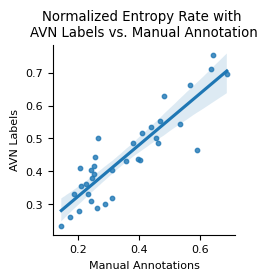

In [18]:

sns.lmplot(data = full_df, x = 'Hand_er_norm', y = 'AVN_er_norm', 
            height = 2.5, aspect = 1, scatter_kws={"s": 10})
plt.xlabel('Manual Annotations')
plt.ylabel('AVN Labels')
plt.title('Normalized Entropy Rate with \nAVN Labels vs. Manual Annotation')

plt.savefig('avn_vs_manual_entropy_rates.svg')

In [6]:
plt.rcParams.update({'font.size': 18})

c:\Users\tkoch\anaconda3\envs\avn4_install_test\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


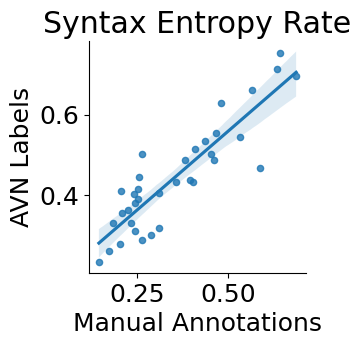

In [17]:

sns.lmplot(data = full_df, x = 'Hand_er_norm', y = 'AVN_er_norm', 
            height = 3.5, aspect = 1, scatter_kws={"s": 20})
plt.xlabel('Manual Annotations')
plt.ylabel('AVN Labels')
plt.title('Syntax Entropy Rate')

plt.savefig('poster_avn_vs_manual_entropy_rates.svg')

In [16]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

In [18]:
# linear regression to get slope and r^2
reg = LinearRegression().fit(np.array(full_df['Hand_er_norm'])[:, np.newaxis], full_df['AVN_er_norm'])
print(reg.score(np.array(full_df['Hand_er_norm'])[:, np.newaxis], full_df['AVN_er_norm']))

0.788921864041213


In [19]:
pearsonr(full_df['Hand_er_norm'], full_df['AVN_er_norm'])

(0.8882127358021911, 1.0988227617165504e-12)

## Comparing Groups

In [18]:
all_birds = pd.read_csv("D:\\Final_Bird_Dataset\\old_Bird_list.csv")
full_df = pd.merge(full_df, all_birds[['Bird_ID', 'Condition']], on = 'Bird_ID')

In [19]:
group_dict = {'Isolate' : 'Isolate', 
              'GFP' : 'Normal', 
              'FP1_KD_pre_tut' : 'FP1 KD', 
              'FP1_KD_post_tut' : 'Normal'}
full_df['Group'] = [group_dict[x] for x in full_df.Condition]

### AVN Labels

In [20]:
isolates_AVN = full_df.AVN_er_norm[full_df.Group== 'Isolate']
normal_AVN = full_df.AVN_er_norm[full_df.Group == 'Normal']
FP1_AVN = full_df.AVN_er_norm[full_df.Group == 'FP1 KD']

In [24]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [25]:
fvalue, pvalue = f_oneway(isolates_AVN, normal_AVN, FP1_AVN)
print(fvalue, pvalue)

15.05305664846605 2.4674595021836464e-05


In [25]:
tukey = pairwise_tukeyhsd(endog = full_df['AVN_er_norm'], 
                          groups = full_df['Group'], 
                          alpha = 0.05)

print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
 FP1 KD Isolate  -0.0153 0.9507 -0.1398  0.1091  False
 FP1 KD  Normal  -0.1913 0.0003 -0.2969 -0.0857   True
Isolate  Normal  -0.1759 0.0004 -0.2765 -0.0753   True
------------------------------------------------------


In [26]:
full_df.Group = full_df.Group.astype('category').cat.set_categories(['Normal', 'Isolate', 'FP1 KD'], ordered = True)

(0.2, 0.85)

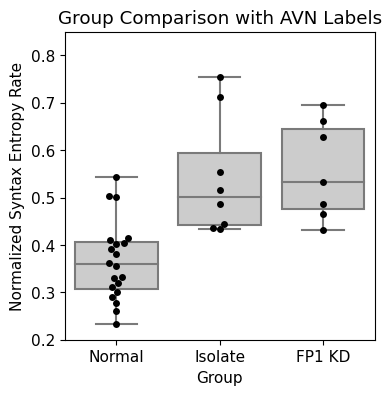

In [28]:
plt.figure(figsize = (4,4))
sns.boxplot(data = full_df, x = 'Group', y = 'AVN_er_norm', color = '0.8')
sns.swarmplot(data = full_df, x = 'Group', y = 'AVN_er_norm', color = 'black', s = 5)
plt.ylabel('Normalized Syntax Entropy Rate')
plt.title('Group Comparison with AVN Labels')
plt.ylim(0.2, 0.85)

c:\Users\tkoch\anaconda3\envs\avn4_install_test\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


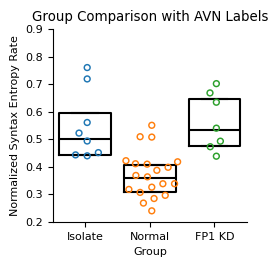

In [34]:
plt.figure(figsize = (2.5,2.5))
sns.boxplot(data = full_df, x = 'Group', y = 'AVN_er_norm', fill = False, color = 'black', 
            fliersize=0, whis= 0, 
            legend = False)
sns.swarmplot(data = full_df, x = 'Group', y = 'AVN_er_norm', hue = 'Group', s = 8, marker = '$\circ$')
plt.ylabel('Normalized Syntax Entropy Rate')
plt.title('Group Comparison with AVN Labels')
plt.ylim(0.2, 0.9)
sns.despine()
plt.savefig('syntax_entropy_rate_group_comparison.svg')


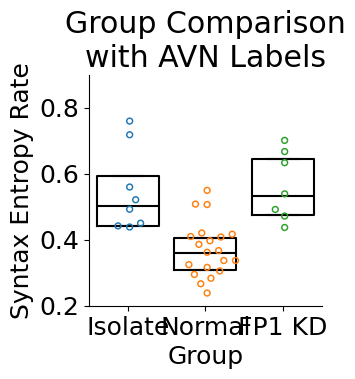

In [24]:
plt.figure(figsize = (3, 3))
sns.boxplot(data = full_df, x = 'Group', y = 'AVN_er_norm', fill = False, color = 'black', 
            fliersize=0, whis= 0, 
            legend = False)
sns.swarmplot(data = full_df, x = 'Group', y = 'AVN_er_norm', hue = 'Group', s = 8, marker = '$\circ$')
plt.ylabel('Syntax Entropy Rate')
plt.title('Group Comparison\nwith AVN Labels')
plt.ylim(0.2, 0.9)
sns.despine()
plt.savefig('poster_syntax_entropy_rate_group_comparison.svg')

## Hand Labels

In [23]:
isolates_Hand= full_df.Hand_er_norm[full_df.Group== 'Isolate']
normal_Hand = full_df.Hand_er_norm[full_df.Group == 'Normal']
FP1_Hand = full_df.Hand_er_norm[full_df.Group == 'FP1 KD']

In [24]:
fvalue, pvalue = f_oneway(isolates_Hand, normal_Hand, FP1_Hand)
print(fvalue, pvalue)

13.453464385263258 5.3346827231377095e-05


In [25]:
tukey = pairwise_tukeyhsd(endog = full_df['Hand_er_norm'], 
                          groups = full_df['Group'], 
                          alpha = 0.05)

print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
 FP1 KD Isolate  -0.0239 0.9096 -0.1649  0.1171  False
 FP1 KD  Normal  -0.2113 0.0003 -0.3292 -0.0933   True
Isolate  Normal  -0.1874 0.0013 -0.3054 -0.0694   True
------------------------------------------------------
